In [31]:
import fastf1
import fastf1.plotting
import pandas as pd
import matplotlib.pyplot as plt

# Enabling the caching of data, so it doesn't need to get downloaded every time
fastf1.Cache.enable_cache('cache')
fastf1.plotting.setup_mpl(color_scheme='fastf1')

In [24]:
session = fastf1.get_session(2024, 'Saudi Arabia', 'R')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 

# Getting familiar with the data

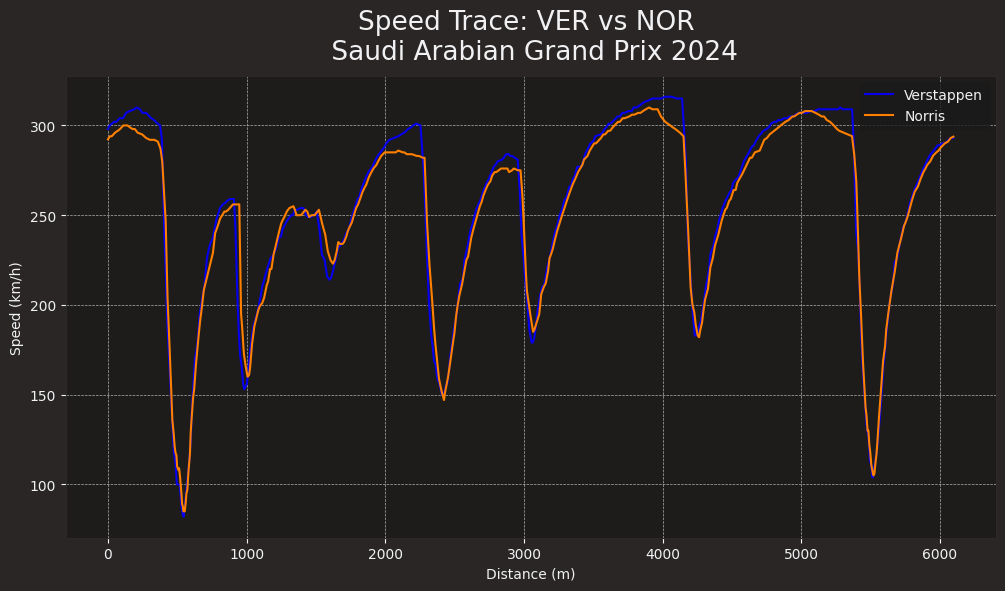

In [30]:
ver_lap = session.laps.pick_drivers('VER').pick_fastest()
nor_lap = session.laps.pick_drivers('NOR').pick_fastest()

ver_tel = ver_lap.get_telemetry()
nor_tel = nor_lap.get_telemetry()

fix, ax = plt.subplots(figsize=(12, 6))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color = fastf1.plotting.get_team_color(ver_lap['Team'], session=session), label = 'Verstappen')
ax.plot(nor_tel['Distance'], nor_tel['Speed'], color = fastf1.plotting.get_team_color(nor_lap['Team'], session = session), label = 'Norris')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Speed (km/h)')
ax.set_title(f"Speed Trace: VER vs NOR \n {session.event['EventName']} 2024")
ax.legend()
plt.grid(True, which = 'both', linestyle='--', linewidth=0.5)
plt.show()